## Environment setup

### Library preparation

In [1]:
%matplotlib notebook
%load_ext autoreload
%autoreload 2

In [2]:
import time, os, io
from PIL import ImageGrab
from IPython.display import Image, display
import clipboard
from scipy import stats
from si_prefix import si_format
from tqdm import tqdm, tqdm_notebook

import pandas as pd
import numpy as np
from io import StringIO 
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
plt.close('all')

import sys 
sys.path.append('..')
from meas_util import *

import qcodes as qc
from qcodes import Station, load_by_run_spec, load_by_guid
from qcodes.instrument.base import Instrument
from qcodes.dataset.experiment_container import (Experiment,
                                                 load_last_experiment,
                                                 new_experiment)
from qcodes.dataset.database import initialise_database
from qcodes.dataset.measurements import Measurement
from qcodes.dataset.plotting import plot_by_id, get_data_by_id, plot_dataset
from qcodes.dataset.data_set import load_by_id
# from qcodes.dataset.data_export import get_shaped_data_by_runidb

C:\Users\KelvinOX25\Anaconda3\lib\site-packages\qcodes\dataset\database.py:13: UserWarning: The module `qcodes.dataset.database` is deprecated.
Public features are available at the import of `qcodes`.
Private features are available in `qcodes.dataset.sqlite.*` modules.
  warnings.warn('The module `qcodes.dataset.database` is deprecated.\n'


In [3]:
from qcodes.instrument_drivers.Lakeshore.Model_372 import Model_372
from qcodes.instrument_drivers.tektronix.AWG3252_Isrc import AWG3252_Isrc
from qcodes.instrument_drivers.HP.HP34401 import HP34401
from qcodes.instrument_drivers.HP.HP34401_DL1201 import HP34401_DL1201
from qcodes.instrument_drivers.Keithley.Keithley_2600_channels import *
from qcodes.instrument_drivers.tektronix.AWG5204_Isrc import AWG5204_Isrc

from qcodes.instrument_drivers.Keithley.Keithley_6220 import Keithley_6220

In [4]:
# #This code saves the image sources in clipboard into png file and copy a short PY code back into clipboard to display the specific png file. 

# import time, os
# dir_path = os.getcwd()
# pngpath = dir_path+"\\img\\{}{}{}-{}{}{}.png".format(time.localtime()[0]%100,time.localtime()[1],time.localtime()[2],time.localtime()[3],time.localtime()[4],time.localtime()[5])

# from PIL import ImageGrab
# img = ImageGrab.grabclipboard()
# img.save(pngpath, 'PNG')

# from IPython.display import Image, display
# display(Image(filename=pngpath))

# import clipboard
# clipboard.copy('display(Image(filename=r\'{}\'))'.format(pngpath))

In [5]:
# display(Image(filename=r'C:\Users\KelvinOX25\Documents\GitHub\measDC\55B1_revist 1D chain\img\19113-124446.png'))

### Instrument nicknames and QC database initialization

In [6]:
try:
   Instrument.close_all()
except KeyError:
   pass    
except NameError:
   pass 

K2602 =  Keithley_2600(name = 'K2602', address = "GPIB::26::INSTR" )
Flux_chA = K2602.smua.curr
Flux_chB = K2602.smub.curr
Bfield =  Flux_chA
Bfield.step = .1e-3
Bfield.inter_delay = .1

LS370 = Model_372(name = 'LS370 input Ch', address = 'GPIB::12::INSTR', terminator='\n')
T8 = LS370.ch08.temperature

htr = LS370htr()
htr.Tset(0.030)
htr.PIDset(30,5,1)
htr.HTRset('off')

# Isrc = AWG5204_Isrc('gen', 'TCPIP0::AWG52000-XXXX::inst0::INSTR', ch = 1, R_bias = 1e9, Attn = 1, timeout = 20)
Isrc = Keithley_6220(name = 'K6220', address = "GPIB::13::INSTR" )
# Isrc = AWG3252_Isrc('gen', 'TCPIP0::192.168.13.32::inst0::INSTR',  R_bias = 1e9, Attn = 1)
Isrc.init()

Vmeter = HP34401_DL1201('meter', 'GPIB0::8::INSTR', Gain = 100)
Vmeter.init('fast 6')

station = qc.Station(Isrc, Vmeter)

print ('Instrument initialization completed.')

Connected to: Keithley Instruments Inc. 2602A (serial:1272049, firmware:2.1.5) in 0.29s
Connected to: LSCI 370 (serial:370665, firmware:04102008) in 0.10s
initialization \\JOSH-PC\Gersh_Labview\DC measurement\LSCI 370 PYTHON_conf.vi
Instrument initialization completed.


## Fridge handling log

In [7]:
# action = 'User: wsLu. Sample: {}. Roughing'.format(SAMPLE)
# action = 'ON Turbo @P1 = 6.47E-2'
# action = 'ON PT @P1 = 8.26E-4. ON HS-STILL, HS-MC'
# action = 'Test Cyro eff., t1hr @P1 = 3.51E-6'
# action = 'Add exchange gas thru v3'
# action = 'Pump coldtrap to P6 = 1.89E-1'
# action = 'Start Pulse_PreCool @T8 = 11.56K'
# action = 'Start Condense_wLN2'
action = 'base T'
# action = 'Warm up to RT'

Tlst = [48, 3.7, 0.661, 0.030, 0.80]
# Tlst = ['dont care']
flow = '0.20'
stillOut = '0'

tAbrStr = time.asctime()
actionStr = '\n\t'+action+'\n'
TPstr = '\tT[1,2,5,6,8]:\t{}\n'.format(Tlst)
misc = '\tFlow = {}, \tStill = {}%\n\n'.format(flow, stillOut)
clipboard.copy(tAbrStr+actionStr+TPstr+misc)

T8.get()

0.0434906

Fri Nov  22 13:05:00 2019
	Collect mixture and warm up
	T[1,2,5,6,8]:	[54.1, 3.86, 0.9, 0.96, 0.98]
	Flow = 0.00, 	Still = 0%

Fri Nov  22 12:25:00 2019
	Start Condense_wLN2
	Flow = 0.00, 	Still = 0%

Fri Nov  22 10:55:00 2019
	Start Pulse_PreCool @T8 = 13K
	T[1,2,5,6,8]:	[55.9, 5.0, 7.1, 9.8, 13]
	Flow = 0.00, 	Still = 0%

Fri Nov  22 10:55:00 2019
	Start Pulse_PreCool @T8 = 13K
	T[1,2,5,6,8]:	[55.9, 5.0, 7.1, 9.8, 13]
	Flow = 0.00, 	Still = 0%

Fri Nov  22 08:55:00 2019
	Start Pulse_PreCool @T8 = 11.56K
	T[1,2,5,6,8]:	[49.6, 4.3, 5.0, 6.5, 8.9]
	Flow = 0.00, 	Still = 0%

Wed Nov  20 22:35:00 2019
	ON PT @P1 = 2.30E-3. ON HS-STILL, HS-MC
	T[1,2,5,6,8]:	['dont care']
	Flow = 0.00, 	Still = 0%

Wed Nov  20 21:20:00 2019
	ON Turbo @P1 = 3.0E-3
	T[1,2,5,6,8]:	['dont care']
	Flow = 0.00, 	Still = 0%

Wed Nov  20 22:35:00 2019
	User: wsLu. Sample: Q1D074, SiOx002. Roughing
	T[1,2,5,6,8]:	['dont care']
	Flow = 0.00, 	Still = 0%



## Scripts

### Measurement scripts

In [9]:
def uduFF_list(amp1=240e-12, amp2=2000e-12, stp1=2e-12, stp2=80e-12):

    i_list_uf = np.linspace(0, amp1, round (amp1/stp1) + 1)
    i_list_uc = np.linspace(amp1, amp2, round ((amp2-amp1)/stp2) + 1)
    i_list = np.append(i_list_uf, i_list_uc)

    i_list_d = [np.linspace(amp2, amp1, round ((amp2-amp1)/stp2) + 1),
                np.linspace(amp1, 0, round (amp1/stp1) + 1),
                np.linspace(0, -1*amp1, round (amp1/stp1) + 1),
                np.linspace(-1*amp1, -1*amp2, round ((amp2-amp1)/stp2) + 1)]
    for lst in i_list_d:
        i_list = np.append(i_list, lst)

    i_list_ucn = np.linspace(-1*amp2, -1*amp1, round ((amp2-amp1)/stp2) + 1)
    i_list_ufn = np.linspace(-1*amp1, 0, round (amp1/stp1) + 1)
    i_list = np.append(i_list, i_list_ucn)
    i_list = np.append(i_list, i_list_ufn)

    return i_list

In [10]:
def setup():
    Isrc.I.set(0)

def cleanup():
    Isrc.I.set(0) 
    Bfield.set(0)

In [11]:
def IVC_udu (amp, stp, Gain, R_bias, Attn, tfsstb = 0.1):
    
    meas = set_meas(Vmeter.V, Isrc.I, setup = setup, cleanup = cleanup)

    Vmeter.set_Gain ( Gain )
    Isrc.set_R_Attn ( R_bias, Attn )
    
    i_list = udu_list(amp, stp)
    ti_list = tqdm_notebook(i_list)

    name_exp(sample = SAMPLE, exp_type = 'IVc @T={}K, B={}A'.format(si_format(T8.get()), si_format(Bfield.get(), precision = 3)))
    with meas.run() as datasaver:
        for i in ti_list:
            
            Isrc.I.set(i)
            time.sleep(tfsstb)
            V = Vmeter.V.get()

            res = [( Isrc.I, i - 22.5e-3/R_bias*Attn ), ( Vmeter.V, V  )]
            datasaver.add_result(*res) 

    cleanup()
    return datasaver.run_id 

In [12]:
def Bperiod_meas (amp=1e-9, Gain=100, R_bias=1e9, Attn=1, B_list = [0]):

    meas = set_meas(Vmeter.V, Bfield, setup = setup, cleanup = cleanup)
    Vmeter.set_Gain (Gain = Gain) 
    Isrc.set_R_Attn (R_bias = R_bias, Attn=Attn)

    tB_list = tqdm_notebook(B_list)

    name_exp(sample = SAMPLE, exp_type = 'B periodicity @T={}K, Ib={}A'.format(si_format(T8.get()), si_format(amp, precision=0)))
    with meas.run() as datasaver:

        for B in tB_list:

            Bfield.set(B)
            time.sleep(0.5)
            Isrc.I.set( 1*amp)
            Vp = Vmeter.V.get()
            Isrc.I.set(-1*amp)
            Vn = Vmeter.V.get()
            delV = Vp-Vn
            volt = [( Bfield, B ), ( Vmeter.V, delV )]

            datasaver.add_result(*volt) 

    cleanup()
    return datasaver.run_id 

In [13]:
def Ic_meas (amp, stp, thr, Gain, R_bias, Attn, tfsstb = 0.1):

    meas = set_meas(Vmeter.V, Isrc.I, setup = setup, cleanup = cleanup)
    Vmeter.set_Gain (Gain) 
    Isrc.set_R_Attn (R_bias, Attn)
    
    i_list_u = np.linspace(0,  amp,  round (amp/stp) + 1)
    ti_list_u = tqdm_notebook(i_list_u)
    i_list_d = np.linspace(0, -amp,  round (amp/stp) + 1)    
    ti_list_d = tqdm_notebook(i_list_d)
    ti_lists = [ ti_list_u ,  ti_list_d]
    
    name_exp(sample = SAMPLE, exp_type = 'sc branch @T={}K, B={}A'.format(si_format(T8.get()), si_format(B, precision = 3)))
    with meas.run() as datasaver:
        for ti_list in ti_lists:
            
            Isrc.I.set(0)
            V_ = Vmeter.V.get()            
            time.sleep(1)
            
            for i in ti_list:
            
                Isrc.I.set(i)
                time.sleep(tfsstb)

                V = Vmeter.V.get()
                dV = V - V_
                V_ = V 
                
                if (abs(dV) > thr)  or (abs(V) > 4e-3 ) : #
                    break

                res = [( Isrc.I, i - 22.5e-3/R_bias*Attn ), ( Vmeter.V, V  )]
                datasaver.add_result(*res) 
    cleanup()
    return datasaver.run_id 

In [14]:
def IVcB_meas (i_list, B_list, thr=1e-3, Gain=100, R_bias=1e9, Attn=1, tfsstb = 0.1):

    Vmeter.set_Gain (Gain = Gain) 
    Isrc.set_R_Attn (R_bias = R_bias, Attn=Attn)

    i_lists = [i_list]
    
    meas = set_meas(Vmeter.V, Isrc.I,setup = setup, cleanup = cleanup)
    tB_list = tqdm_notebook(B_list)
    for B in tB_list:

        name_exp(sample = SAMPLE, exp_type = 'full IVc(B) @T={}K, B={}A'.format(si_format(T8.get()), si_format(B, precision =3)))
        with meas.run() as datasaver:

            Bfield.set(B)
            for i_list in i_lists:

                Isrc.I.set(0)
                V_ = Vmeter.V.get()
                time.sleep(1)

                for i in i_list:

                    Isrc.I.set(i)
                    time.sleep(tfsstb)

                    V = Vmeter.V.get()
                    dV = V - V_
                    V_ = V

                    if  (abs(V) > 6.4e-3) : #(abs(dV) > thr)  or
                        break

                    res = [( Isrc.I, i - 22.5e-3/R_bias*Attn ), ( Vmeter.V, V  )]
                    datasaver.add_result(*res) 
    cleanup()
    return datasaver.run_id 

*What is the difference between IVc_ada and IVcB_ada?*

In [15]:
# adaptive step size with while loop
def IVc_ada(npts_B = 51, thr=1e-3, Gain=100, R_bias=1e9, Attn=1, tfsstb = 0.1):
    ZF =  0.004e-3
    FF =  0.224e-3
    dF =  0.250e-3
    midF = 0.154e-3

    maxI    = 300e-9
    step_ff = 0.2e-9
    step_f  =  10e-9
    step_c  =  50e-9
    
    thr = thr

    B_list = np.linspace(ZF, ZF, npts_B)
    tB_list = tqdm_notebook(B_list)

    Vmeter.set_Gain (Gain = Gain) 
    Isrc.set_R_Attn (R_bias = R_bias, Attn=Attn)

    for B in tB_list:
        meas = set_meas(Vmeter.V, Isrc.I, setup = setup, cleanup = cleanup)

        name_exp(sample = SAMPLE, exp_type = 'IVC @T ={:2.1f}mK, B = {}A'.format(T8.get()/1e-3, si_format(B)) )  
        with meas.run() as datasaver:

                Bfield.set(B)

                for pm in [1, -1]:

                    i = 22.5*1e-3/R_bias

                    Isrc.I.set(i)
                    time.sleep(1)
                    V_off = Vmeter.V.get()
                    V_ = V_off
                    time.sleep(1)
                    
                    step = step_f
                    while abs(i) < maxI:

                        Isrc.I.set(i)
                        time.sleep(tfsstb)

                        V = Vmeter.V.get()
                        dV = V - V_
                        V_ = V

                        res = [( Isrc.I, i - 22.5e-3/R_bias*Attn ), ( Vmeter.V, V  )]

                        datasaver.add_result(*res) 

                        if (abs(dV) > thr)  or (abs(V - V_off) > thr ):
                            step = step_c
                        else:
                            if 122-9 < i < 135-9:
                                step = step_ff
                            elif -122e-9 < i < -113e-9:
                                step = step_ff 
                            else:
                                step = step_f
                            
                        i += pm*step

    cleanup()
    return datasaver.run_id 

In [16]:
def meas_Voffset(i):
    V_off = 0
    N = 10
    Isrc.I.set(i)


    for j in range(N):
#         time.sleep(.1)
        V_off += Vmeter.V.get()
    return V_off/N

In [17]:
# _updated_ adaptive step size with while loop
def IVc_adaptive(Gain=100, R_bias=1e9, Attn=1, find_istep=None, keepgoing=None, 
                 direction ='pm', record_back = False):

    def write_data(i,  v):
            
            
            res = [( Isrc.I, i ), ( Vmeter.V, v  )]
            datasaver.add_result(*res)
            return i - I_off , V - V_off

    if find_istep is None:
        raise Exception('Pls define find_step function to set the rules of current increasing')

    if keepgoing is None:
        raise Exception('Pls define keepgoing function to set the while-loop condition')

    Vmeter.set_Gain (Gain = Gain) 
    Isrc.set_R_Attn (R_bias = R_bias, Attn=Attn)
    
    I_off =  22.5e-3/R_bias*Attn

    N_back = 51
    
    dir_map = {'pm':[1,-1], 'p':[1], 'm':[-1] }
    sign = dir_map[direction]                             
    
    meas = set_meas(Vmeter.V, Isrc.I, setup = setup, cleanup = cleanup)

    name_exp(sample = SAMPLE, exp_type = 'IVC @T ={:2.1f}mK'.format(T8.get()/1e-3 ) ) 
    with meas.run() as datasaver:
        
        for pm in sign:   #to measure in + and - directions

            i = I_off
            V_off = meas_Voffset(i)
            V = V_off
#             print(V_off)
                
            while keepgoing(i, V):
                

                write_data(i - I_off,  V - V_off)

                step = find_istep(i,V, B = Bfield.get() )
                i += pm*step
                Isrc.I.set(i)
#                 time.sleep(0.1)
                V = Vmeter.V.get()

            for i in np.linspace(i, I_off, N_back):
                Isrc.I.set(i)
               
                if record_back:
#                     time.sleep(0.1)
                    V = Vmeter.V.get()
                    write_data(i - I_off,  V - V_off)
            
    return datasaver.run_id 

In [19]:
# _updated_ adaptive step size with while loop
def fast_IVc_adaptive(Gain=100, R_bias=1e9, Attn=1, find_istep=None, keepgoing=None,
                      direction ='pm', record = None, datasaver = datasaver):

    Is = []
    Vs = []
    
    def write_data(i,  v):
            
            
            res = [( Isrc.I, i ), ( Vmeter.V, v  )]
            datasaver.add_result(*res)
            return i - I_off , V - V_off

    if find_istep is None:
        raise Exception('Pls define find_step function to set the rules of current increasing')

    if keepgoing is None:
        raise Exception('Pls define keepgoing function to set the while-loop condition')

    Vmeter.set_Gain (Gain = Gain) 
    Isrc.set_R_Attn (R_bias = R_bias, Attn=Attn)
    
    I_off =  22.5e-3/R_bias*Attn

    N_back = 51
    
    dir_map = {'pm':[1,-1], 'p':[1], 'm':[-1] }
    sign = dir_map[direction]                             
    
        
    for pm in sign:   #to measure in + and - directions

        i = I_off
        V_off = meas_Voffset(i)
        V = V_off

        while keepgoing(i, V):
            
            Is.append(i)
            Vs.append(V)
            
            if 'u' in record:
                write_data(i - I_off,  V - V_off)

            step = find_istep(i,V, B = Bfield.get() )
            i += pm*step
            Isrc.I.set(i)
            time.sleep(0.05)
            V = Vmeter.V.get()


        for i in np.linspace(i, I_off, N_back):
            Isrc.I.set(i)

            if 'd' in record:
                time.sleep(0.05)
                V = Vmeter.V.get()
                write_data(i - I_off,  V - V_off)

    return Is, Vs 

NameError: name 'datasaver' is not defined

In [20]:
def keepgoing(i, v):
    Imax = 250e-9
    if abs(i) < Imax:
        return True
    else:
        return False

In [21]:
def istep_4Isw_B(i, v, B):
    
    step_ff =   .2e-9
    step_f  =  5e-9
    step_c  =  20e-9
    

    V_th = 200e-6
        
    if abs(v) < V_th:
        step = step_f
    else:
        step = step_c

    return step

## Hystogram methods

In [22]:
def extract_Isw_by_id (idx):
    
    alldata = get_data_by_id(idx)
    
    Is = alldata[0][0]['data']
    Vs = alldata[0][1]['data']

        
    return extract_Isw (Is,Vs)

def extract_Isw (Is,Vs):
    
        if len( Is )== 0 or len( Vs )== 0 :
            Isw, R0 = np.nan, np.nan
            return Isw, R0
        
        Isw = abs(np.max(Is)) 
        

        
        return Isw

In [108]:
# adaptive step size with while loop
def IVcB_ada(npts_B = 51, thr=1e-3, Gain=100, R_bias=1e9, Attn=1, tfsstb = 0.1):
    ZF =  0.004e-3
    FF =  0.224e-3
    dF =  0.250e-3
    midF = 0.154e-3

#     maxI = 40e-9
#     step_ff = 2e-12
#     step_f = 10e-12
#     step_c = 200e-12
#     maxI    = 300e-9
#     step_ff = 200e-12
#     step_f  = 200e-12
#     step_c  =   4e-9
    maxI    = 300e-9
    step_ff =   2e-9
    step_f  =   2e-9
    step_c  =  50e-9
    
    thr = thr

    B_list = np.linspace(ZF - 2.0*dF, ZF + 2.0*dF, npts_B)
    tB_list = tqdm_notebook(B_list)

    Vmeter.set_Gain (Gain = Gain) 
    Isrc.set_R_Attn (R_bias = R_bias, Attn=Attn)

    for B in tB_list:
        meas = set_meas(Vmeter.V, Isrc.I, setup = setup, cleanup = cleanup)

        name_exp(sample = SAMPLE, exp_type = 'Bscan IVC @T ={:2.1f}mK, B = {}A'.format(T8.get()/1e-3, si_format(B)) )  
        with meas.run() as datasaver:

                Bfield.set(B)


                
                for pm in [1, -1]:
                    if B < midF:
                        step = step_f
                    else:
                        step = step_ff

                    i = 22.5*1e-3/R_bias*Attn

                    Isrc.I.set(i)
                    time.sleep(1)
                    V_off = Vmeter.V.get()
                    V_ = V_off
                    time.sleep(1)

                    while abs(i) < maxI:

                        Isrc.I.set(i)
                        time.sleep(tfsstb)

                        V = Vmeter.V.get()
                        dV = V - V_
                        V_ = V

                        res = [( Isrc.I, i - 22.5e-3/R_bias*Attn ), ( Vmeter.V, V  )]

                        datasaver.add_result(*res) 

                        if (abs(dV) > thr)  or (abs(V - V_off) > thr ) : #
                            step = step_c

                        i += pm*step

    cleanup()
    return datasaver.run_id 

In [24]:
# # Use this code for T-dependent tasks
# # Using PID 30,5,1 & htr range 10mA for T8 upto 550mK
# # The LS370 htr driver was coded in meas_util.py instead of qcode  
 
# setT8_lst = [.100, .150, .200, .250, .300] 

# tolerT8 = 0.02
# chkrepeat = 20
# chkperiod_sec = 2

# Tnow_alllst = []
# timer_lst = []

# htr.HTRset('10mA')

# for setT8 in setT8_lst:
# #     htr.setpoint(setT8)
#     htr.Tset(setT8)
#     print('ramping T8 to {}K...'.format(si_format(setT8)))
#     if setT8 < 60e-3:
#         time.sleep(300)
#     else:
#         time.sleep(30)
#     Tnow_lst = []

#     t0 = time.time()
#     count_T = 0
#     while count_T < chkrepeat:
#         T_now = T8.get()
#         if (1-tolerT8)*setT8 <= T_now <= (1+tolerT8)*setT8 :
#             count_T +=1
#             Tnow_lst.append(T_now)
#             time.sleep(chkperiod_sec)
#         elif count_T >= 1 :
#             count_T -=1
#     t1 = time.time()
    
#     timer_lst.append(t1-t0)
#     Tnow_alllst.append(Tnow_lst)

#     # insert here the repeatative work to be done at each T
#     hist_meas()

# # htr.setpoint(0.030)
# htr.Tset(0.030)

In [25]:
def RTc (dataPts = 100, Gain = 100, R_bias = 1e9, Attn = 1, tfsstb = 0.1, I_bias = 0.4e-9, T_str = 0):
    
    meas = set_meas(Vmeter.V, Isrc.I, setup = setup, cleanup = cleanup)

    Vmeter.set_Gain ( Gain )
    Isrc.set_R_Attn ( R_bias, Attn )
    pts_list = np.arange(1, dataPts)
    tpts_list = tqdm_notebook(pts_list)

    name_exp(sample = SAMPLE, exp_type = 'RTc')
    with meas.run() as datasaver:
        for j in tpts_list:

            Ib_list = udu_list(1*I_bias, 0.5*I_bias)
            V1_list = []
            T8_lst = []
            for Ib in Ib_list:
                Isrc.I.set(Ib)
                time.sleep(tfsstb)
                V1_list = np.append(V1_list, Vmeter.V.get())
                T8_lst.append(T8.get())
            T_now = sum(T8_lst)/len(T8_lst)
            R_now, intercept, r_value, p_value, std_err = stats.linregress(Ib_list, V1_list)
            
            res = [( Isrc.I, T_now ), ( Vmeter.V, R_now )]
            with open('CH0 T {}.log'.format(time.strftime('%d-%m-%y', time.localtime())),'a+') as fp:
                fp.write(time.strftime(' %d-%m-%y,%H:%M:%S,{}'.format(R_now), time.localtime())+'\n')
                fp.close
            with open('CH8 T {}.log'.format(time.strftime('%d-%m-%y', time.localtime())),'a+') as fp:
                fp.write(time.strftime(' %d-%m-%y,%H:%M:%S,{}'.format(T_now), time.localtime())+'\n')
                fp.close

#             print('Current T8= {}K'.format(si_format(T8.get()), end='\r'))
            sys.stdout.write("\rCurrent T8= {}K".format(si_format(T8.get())))
            sys.stdout.flush()
            datasaver.add_result(*res)
            if T_str == 300:
                time.sleep(54.5)
            else:
                time.sleep(0.05)

    cleanup()
    return datasaver.run_id 

### Data processing scripts

In [26]:
def extract_Isw_R0 (Is,Vs):

    Isw = (np.max(Is) - np.min(Is) ) /2

    order = Is.argsort()        
    Is, Vs = Is[order], Vs[order]
    n = len(Is)
    n_min, n_max = np.int(n/3), np.int(2*n/3)        
    n_sl = slice(n_min, n_max)

    R0 = np.mean(np.diff(Vs[n_sl])) / np.mean(np.diff(Is[n_sl]))        
    return Isw, R0

def extract_Isw_R0_by_id (idx):
    
    alldata = get_data_by_id(idx)
    
    Is = alldata[0][0]['data']
    Vs = alldata[0][1]['data']
        
    return extract_Isw_R0 (Is,Vs)

In [27]:
def databyid (run_id: int, **kwargs):
    from qcodes.dataset.data_set import load_by_id

    dataset = load_by_id(run_id)
    title = f"#{run_id}, Exp {dataset.exp_name} ({dataset.sample_name})"
    alldata = get_data_by_id(run_id)
    
    return ({'title':title, 'alldata':alldata})

def DFMbyid(run_id: int):
    data = databyid(run_id)
    DTF = {data['alldata'][0][0]['name'] : pd.Series(data['alldata'][0][0]['data'], index = np.arange(len(data['alldata'][0][0]['data']))), 
           data['alldata'][0][1]['name'] : pd.Series(data['alldata'][0][1]['data'], index = np.arange(len(data['alldata'][0][0]['data'])))} 
    DTF = pd.DataFrame(DTF)
    return DTF

def dataread (filename, splitkw = '!DATASTR!'):
    with open(filename,'r') as file:
        rawtxt = file.read()
        splittxt = rawtxt.split(splitkw)    
    return(splittxt)

def filetoDFM (filename):
    datatxt = dataread(filename = filename)
    datastr = io.StringIO(datatxt[1])
    DataFM = pd.read_csv(datastr, sep = '\t')
    DataFM = DataFM.drop(DataFM.index[0])
    DataFM = DataFM.astype(float)
    return(DataFM, datatxt[0])

def pltMaxMin(lst, pMF = 1.1):
    pMin = lst.mean()-pMF*(lst.max()-lst.min())/2
    pMax = lst.mean()+pMF*(lst.max()-lst.min())/2
    pPos = (lst.mean()-lst.min())*pMF+lst.min()
    return(pMin,pMax,pPos)

def xy_by_id(idx):
    alldata = get_data_by_id(idx)
    
    x = alldata[0][0]['data']
    y = alldata[0][1]['data']
    
    return x,y

In [28]:
# # Quick visualization of the results

# qc.config["core"]["db_location"] = r'\\JOSH-PC\OurData_OneDrive\Experiments_{}.db'.format('70B1N7')
# initialise_database()
# f,ax=plt.subplots()

# label = ['a',
#          'b',
#          'v',
#          'meas on Nov 11th']

# for i,v in enumerate([105, 971,1092,1095]):
#     data = get_data_by_id(v)
#     Is = data[0][0]['data']
#     Vs = data[0][1]['data']
#     ax.plot(Is, Vs, '.', ls='-',label = '{}'.format(label[i]))

# ax.legend()

## Devices and measurement setups

### Device overview

- ID: Q1D079: large JJ chains with large EJ to study noise
 - N0: (1ab,2ab), $R_{RT, 2pb} = 24.3k\Omega$ 
 - N6: (3ab,4ab), $R_{RT, 2pb} = 2.15k\Omega$
 - N5: (6ab,7ba), $R_{RT, 2pb} = 27.1k\Omega$
 - N3: (8ab,9ab), $R_{RT, 2pb} = 520k\Omega$ (9a is broken)
 - N1: (11ab,12ab), $R_{RT, 2pb} = 290k\Omega$
 
- Instrumentation
 - $R_{G, 2pb}$ = OVFL on all devices
 - $R_{coil} = 1.24k\Omega$
 - $R_{therm} = 1.056k\Omega$

- Device scheme for Q1D079
 - Type: 1D chain with 16 SQUIDs or single SQUID (N1 & N6), pentagon capacitors with larger spacing to accomodate larger junction area design.
 - Shunting capacitor C0: No Pt yet.
 - C0 area: 
 - SQUID area: 
 - Junction area:
 - Oxidation: 375 torr "wet" oxigen, 30min (by Plamen)

#### Junction parameters
- D079 site1: 
 - [RN_JJ (kohm), Rs_JJ (kohm-um^2)] = [580.0, 23.30382]
 - [I_AB (nA), EJ (mK)] = [1.10331, 26.29969] (converted to SQUID)
 - [C_JJQP (fF), EC (mK)] = [1.56645, 593.45954]
 - [C0 (fF), EC0 (mK)] = [463.10944, 2.00735]
 - [Freq_plasma (GHz))] = [0.42821]
 - [Q, Beta, EJ/EC] = [722.7, 522278.1, 13.1]

- D079 site3: 
 - [RN_JJ (kohm), Rs_JJ (kohm-um^2)] = [65.0, 14.87825]
 - [I_AB (nA), EJ (mK)] = [9.84493, 234.67416] (converted to SQUID)
 - [C_JJQP (fF), EC (mK)] = [10.3096, 90.17078]
 - [C0 (fF), EC0 (mK)] = [463.10944, 2.00735]
 - [Freq_plasma (GHz))] = [1.27914]
 - [Q, Beta, EJ/EC] = [241.9, 58531.2, 116.9]

- D079 site5: 
 - [RN_JJ (kohm), Rs_JJ (kohm-um^2)] = [3.375, 13.54702]
 - [I_AB (nA), EJ (mK)] = [189.60606, 4519.6505] (converted to SQUID)
 - [C_JJQP (fF), EC (mK)] = [195.75, 4.74904]
 - [C0 (fF), EC0 (mK)] = [463.10944, 2.00735]
 - [Freq_plasma (GHz))] = [5.61354]
 - [Q, Beta, EJ/EC] = [55.1, 3039.1, 2251.5]

- D079 site6: 
 - [RN_JJ (kohm), Rs_JJ (kohm-um^2)] = [4.3, 16.76434]
 - [I_AB (nA), EJ (mK)] = [148.81871, 3547.4001] (converted to SQUID)
 - [C_JJQP (fF), EC (mK)] = [190.06, 4.89122]
 - [C0 (fF), EC0 (mK)] = [463.10944, 2.00735]
 - [Freq_plasma (GHz))] = [4.97324]
 - [Q, Beta, EJ/EC] = [62.2, 3872.1, 1767.2]

- D079 site0: 
 - [RN_JJ (kohm), Rs_JJ (kohm-um^2)] = [3.0375, 11.50227]
 - [I_AB (nA), EJ (mK)] = [210.6734, 5021.83389] (converted to SQUID)
 - [C_JJQP (fF), EC (mK)] = [184.535, 5.03766]
 - [C0 (fF), EC0 (mK)] = [463.10944, 2.00735]
 - [Freq_plasma (GHz))] = [5.91719]
 - [Q, Beta, EJ/EC] = [52.3, 2735.2, 2501.7]

### Biasing scheme

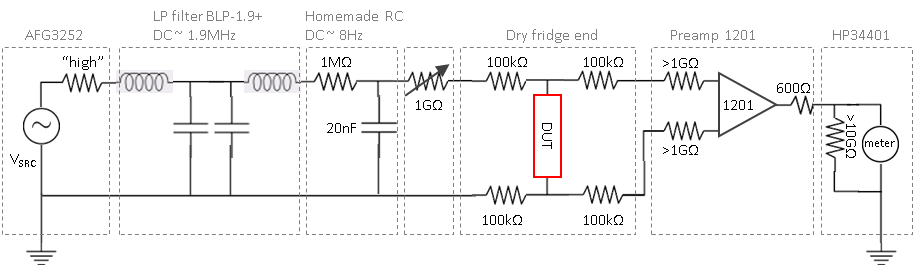

In [20]:
display(Image(filename=r'C:\Users\KelvinOX25\Documents\GitHub\DC meas\img\191026-183349.png'))

## Measurement

### List of run_ids

In [111]:
ZF =  0.004e-3
FF =  0.224e-3
dF = 0.250e-3
midF = 0.154e-3

pd.set_option("display.precision", 3)

In [83]:
key = [                  'ids', 'T',    'B',                                  'Vthr', 'comments'        ]  
lst = [[                   [9],  16e+0, np.array([ZF])                      , np.nan, 'quick IVc meas'  ],
       [                  [10],  43e-3, np.array([ZF])                      , np.nan, 'quick IVc meas'  ]]
        
ex79N0 = pd.DataFrame( data = list(zip(*lst)), columns = range(len(lst)), index = key ).transpose()

**pls update**

In [112]:
key = [                  'ids', 'T',    'B',                                  'Vthr', 'comments'        ]  
lst = [[                   [1],  16e+0, np.array([ZF])                      , np.nan, 'quick IVc meas'  ],
       [                   [2],  43e-3, np.array([ZF])                      , np.nan, 'quick IVc meas'  ],
       [      range( 74,104+1),  43e-3, np.array([ZF])                      , np.nan, 'Ic stats'        ],
       [      range(105,107+1),  43e-3, np.array([ZF,midF,FF])              , np.nan, 'quick IVc vs B'  ],
       [      range(108,158+1),  50e-3, np.linspace(ZF, ZF + 1.0*dF, 51)    ,   1e-3, 'IVc vs B'        ],
       [      range(159,209+1), 100e-3, np.linspace(ZF, ZF + 1.0*dF, 51)    ,   1e-3, 'IVc vs B'        ],
       [      range(210,260+1), 150e-3, np.linspace(ZF, ZF + 1.0*dF, 51)    ,   1e-3, 'IVc vs B'        ],
       [      range(261,311+1), 200e-3, np.linspace(ZF, ZF + 1.0*dF, 51)    ,   1e-3, 'IVc vs B'        ],
       [      range(312,362+1), 250e-3, np.linspace(ZF, ZF + 1.0*dF, 51)    ,   1e-3, 'IVc vs B'        ],
       [      range(363,413+1), 300e-3, np.linspace(ZF, ZF + 1.0*dF, 51)    ,   1e-3, 'IVc vs B'        ],
       [      range(414,464+1), 350e-3, np.linspace(ZF, ZF + 1.0*dF, 51)    ,   1e-3, 'IVc vs B'        ],
       [      range(465,515+1), 400e-3, np.linspace(ZF, ZF + 1.0*dF, 51)    ,   3e-5, 'IVc vs B'        ],
       [      range(516,566+1), 450e-3, np.linspace(ZF, ZF + 1.0*dF, 51)    ,   3e-5, 'IVc vs B'        ],
       [      range(567,617+1), 500e-3, np.linspace(ZF, ZF + 1.0*dF, 51)    ,   3e-5, 'IVc vs B'        ],
       [      range(618,668+1), 550e-3, np.linspace(ZF, ZF + 1.0*dF, 51)    ,   3e-5, 'IVc vs B'        ],
       [      range(669,719+1), 600e-3, np.linspace(ZF, ZF + 1.0*dF, 51)    ,   3e-5, 'IVc vs B'        ],
       [      range(763,813+1),  50e-3, np.linspace(ZF, ZF + 1.0*dF, 51)    ,   3e-5, 'IVc vs B I_ff'   ],
       [      range(814,864+1), 150e-3, np.linspace(ZF, ZF + 1.0*dF, 51)    ,   3e-5, 'IVc vs B I_ff'   ],
       [      range(865,915+1), 250e-3, np.linspace(ZF, ZF + 1.0*dF, 51)    ,   3e-5, 'IVc vs B I_ff'   ],
       [      range(916,966+1), 350e-3, np.linspace(ZF, ZF + 1.0*dF, 51)    ,   3e-5, 'IVc vs B I_ff'   ],
       [     range(967,1017+1), 450e-3, np.linspace(ZF, ZF + 1.0*dF, 51)    ,   3e-5, 'IVc vs B I_ff'   ],
       [    range(1018,1068+1), 550e-3, np.linspace(ZF, ZF + 1.0*dF, 51)    ,   3e-5, 'IVc vs B I_ff'   ],
       [    range(1069,1119+1), 650e-3, np.linspace(ZF, ZF + 1.0*dF, 51)    ,   3e-5, 'IVc vs B I_ff'   ],
       [    range(1234,1284+1),  50e-3, np.linspace(ZF, ZF + 2.0*dF, 51)    ,   3e-5, 'IVc vs B I_ff'   ]]
        
ex79N6 = pd.DataFrame( data = list(zip(*lst)), columns = range(len(lst)), index = key ).transpose()4

SyntaxError: invalid syntax (<ipython-input-112-97531e6ab41a>, line 27)

In [66]:
key = [                  'ids', 'T',    'B',                                  'Vthr', 'comments'        ]  
lst = [[                   [1],  16e+0, np.array([ZF])                      , np.nan, 'quick IVc meas'  ],
       [               [2,3,4],  43e-3, np.array([ZF])                      , np.nan, 'quick IVc meas'  ]]
        
ex79N5 = pd.DataFrame( data = list(zip(*lst)), columns = range(len(lst)), index = key ).transpose()

In [47]:
key = [                  'ids', 'T',    'B',                                  'Vthr', 'comments'        ]  
lst = [[                   [9],  16e+0, np.array([ZF])                      , np.nan, 'quick IVc meas'  ]]
        
ex79N3 = pd.DataFrame( data = list(zip(*lst)), columns = range(len(lst)), index = key ).transpose()

Upgrading database; v0 -> v1: : 0it [00:00, ?it/s]
Upgrading database; v1 -> v2: 100%|██████████████| 1/1 [00:00<00:00, 55.55it/s]
Upgrading database; v2 -> v3: : 0it [00:00, ?it/s]
Upgrading database; v3 -> v4: : 0it [00:00, ?it/s]
Upgrading database; v4 -> v5: 100%|██████████████| 1/1 [00:00<00:00, 45.45it/s]
Upgrading database; v5 -> v6: : 0it [00:00, ?it/s]
Upgrading database; v7 -> v8: 100%|██████████████| 1/1 [00:00<00:00, 47.62it/s]


In [81]:
key = [                  'ids', 'T',    'B',                                  'Vthr', 'comments'        ]  
lst = [[                   [2],  16e+0, np.array([ZF])                      , np.nan, 'quick IVc meas'  ],
       [                   [3],  65e-3, np.array([ZF])                      , np.nan, 'quick IVc meas'  ],
       [                   [6],  43e-3, np.array([ZF])                      , np.nan, 'quick IVc meas'  ]]
        
ex79N1 = pd.DataFrame( data = list(zip(*lst)), columns = range(len(lst)), index = key ).transpose()

### Plans and list of ToDo-es

**Plan**
- Read hist and clean up the codes
- Better htr coding control protocol
- 1303

**Selected meas to be done**
- Careful IVc_B scan (maybe we can get that from hist already)
- Compare IVc(delay 0.1 vs 0.5)
- Compare hist(6221 vs AWG)

### Runs

In [124]:
IVC_udu (amp=400e-9, stp=4e-9, Gain=100, R_bias=11.2e6, Attn=1, tfsstb = 0.5)

Starting experimental run with id: 1367



1367

<IPython.core.display.Javascript object>


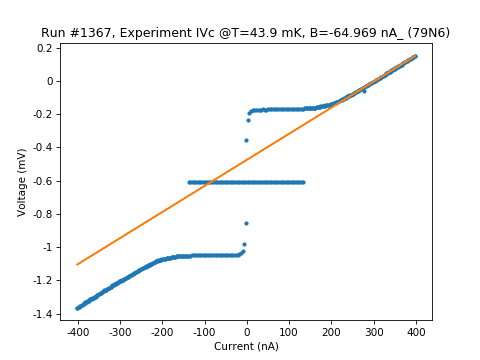

1569.9769230769234 -0.00047538450542582356


In [132]:
fig, ax = plt.subplots()
plot_by_id(1367, axes = ax, marker = '.', ls ='')

I, V = xy_by_id(1367)

idx = np.where(I>300e-9)

a,b = np.polyfit(I[idx], V[idx], 1)

print(a,b)

ax.plot(I, I*a + b)

<IPython.core.display.Javascript object>


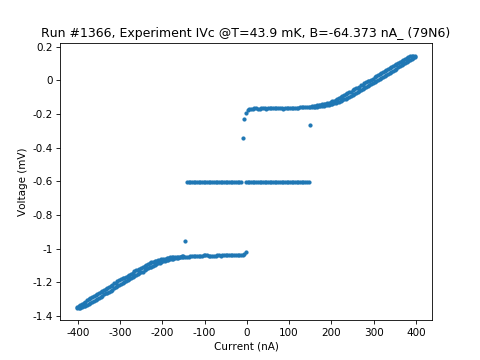

([<matplotlib.axes._subplots.AxesSubplot at 0xb15db50>], [None])

In [126]:
plot_by_id(1366, marker = '.', ls ='')

In [109]:
IVcB_ada(npts_B = 51, thr=250e-6, Gain=100, R_bias=11.2e6, Attn=1, tfsstb = 0.1)

Starting experimental run with id: 1315
Starting experimental run with id: 1316
Starting experimental run with id: 1317
Starting experimental run with id: 1318
Starting experimental run with id: 1319
Starting experimental run with id: 1320
Starting experimental run with id: 1321
Starting experimental run with id: 1322
Starting experimental run with id: 1323
Starting experimental run with id: 1324
Starting experimental run with id: 1325
Starting experimental run with id: 1326
Starting experimental run with id: 1327
Starting experimental run with id: 1328
Starting experimental run with id: 1329
Starting experimental run with id: 1330
Starting experimental run with id: 1331
Starting experimental run with id: 1332
Starting experimental run with id: 1333
Starting experimental run with id: 1334
Starting experimental run with id: 1335
Starting experimental run with id: 1336
Starting experimental run with id: 1337
Starting experimental run with id: 1338
Starting experimental run with id: 1339


1365

In [52]:
# B_list = np.linspace( 0, 0.500e-3, 501)
B_list = udu_list(amp=0.500e-3, stp=0.005e-3)
Bperiod_meas (amp=100e-9, Gain=100, R_bias=1e7, Attn=1, B_list = B_list)

Starting experimental run with id: 13



13

### Temp space for hist

In [29]:

def if_Vth(i, v):
    
    V_th = 300e-6        
    if abs(v) < V_th:
        return True
    else:
        return False

    
def istep_coarse(i, v, **kwarg):
    
    step_c  =  20e-9
    return step_c    

def gen_istep_4hyst(Ith):
    
    def istep_4hyst(i, v, **kwarg):
        N_coarse = 11
        step_f  =  0.2e-9
        if abs(i) < Ith:
            step = Ith/N_coarse
        else:
            step = step_f
        
        return step
    
    return istep_4hyst
        

In [113]:
SAMPLE = '79N6'
qc.config["core"]["db_location"] = r'\\JOSH-PC\OurData_OneDrive\Experiments_{}.db'.format(SAMPLE)

In [136]:
meas = set_meas(Vmeter.V, Isrc.I, setup = setup, cleanup = cleanup)

name_exp(sample = SAMPLE, exp_type = 'IVC for hist @T ={:2.1f}mK'.format(T8.get()/1e-3) )  
with meas.run() as datasaver:

    Is, Vs = fast_IVc_adaptive(Gain=100, R_bias=10e6, Attn=1, find_istep = istep_coarse, 
                               keepgoing =  if_Vth, direction = 'p', record = 'u')
    
print(Is)
print(extract_Isw (Is, Vs))


Starting experimental run with id: 1214


Could not commit to database; This DataSet is complete, no further results can be added to it.


[2.25e-09, 2.225e-08, 4.225e-08, 6.224999999999999e-08, 8.224999999999999e-08]
8.224999999999999e-08


In [31]:
def hist_meas():
    meas = set_meas(Vmeter.V, Isrc.I, setup = setup, cleanup = cleanup)

    name_exp(sample = SAMPLE, exp_type = 'IVC for hist @T ={:2.1f}mK'.format(T8.get()/1e-3) )  
    with meas.run() as datasaver:

        Is, Vs = fast_IVc_adaptive(Gain=100, R_bias=10e6, Attn=1, find_istep = istep_coarse, 
                                   keepgoing =  if_Vth, direction = 'p', record = 'u',
                                   datasaver = datasaver)

    coarse_Isw =  extract_Isw (Is, Vs)
    print('Isw_coarse = {:2.0f} nA \n'.format(coarse_Isw /1e-9))

    istep_4hyst = gen_istep_4hyst(0.8*coarse_Isw)


    Isws = []
    for j in tqdm_notebook(range(250)):
        Is, Vs = fast_IVc_adaptive(Gain=100, R_bias=10e6, Attn=1, find_istep = istep_4hyst,
                             keepgoing =  if_Vth,  direction = 'p', record = 'None',
                                  datasaver = None)

        fine_Isw =  extract_Isw (Is, Vs)
        Isws.append(fine_Isw)


    counts, bins = np.histogram(Isws)     
    N_try = qc.Parameter('try')    

    meas = set_meas( Isrc.I, N_try, setup = setup, cleanup = cleanup)

    name_exp(sample = SAMPLE, exp_type = 'Isw for Histogram dI = .2nA @T ={:2.1f}mK'.format(T8.get()/1e-3) )  
    with meas.run() as datasaver: 
        for j, I in enumerate(Isws):
            res = [ ( N_try, j  ) ,( Isrc.I, I ),]

            datasaver.add_result(*res)   

In [71]:
cos_to_B(.0)

0.0002342831853071796

In [68]:

def cos_to_B(cos):
    FF_ = .232e-3
    ZF_ = .004e-3
    return np.arccos( cos)*(2* (FF_ - ZF_)/np.pi + ZF_  )

In [75]:
def plot_hist_by_id(idx, ax = None):
    _, Isws = xy_by_id(idx)
    if ax is None:

        fig, ax = plt.subplots()

    ax.hist(Isws, bins = 201, cumulative = True )
    return Isws

In [85]:
def save_hist(Isws, label = ''):     
    N_try = qc.Parameter('try')    

    meas = set_meas( Isrc.I, N_try, setup = setup, cleanup = cleanup)
    name = '{:} @T ={:2.1f}mK'.format(label, T8.get()/1e-3)
    name_exp(sample = SAMPLE, exp_type = name )  
    with meas.run() as datasaver: 
        for j, I in enumerate(Isws):
            res = [ ( N_try, j  ) ,( Isrc.I, I ),]

            datasaver.add_result(*res)
            
    print('Run # {:1.0f}, {:} saved'.format(datasaver.run_id, name))

In [ ]:
for cos in np.linspace(1,0,11):
    B = cos_to_B(cos)
    Bfield.set(B)
    Isws =  meas_hist(1000)
    save_hist(Isws, '6220, cos = {:1.2f}'.format(cos))
Bfield.set(0)


Starting experimental run with id: 1368
Run # 1368, 6220, cos = 1.00 @T =42.7mK saved


<IPython.core.display.Javascript object>


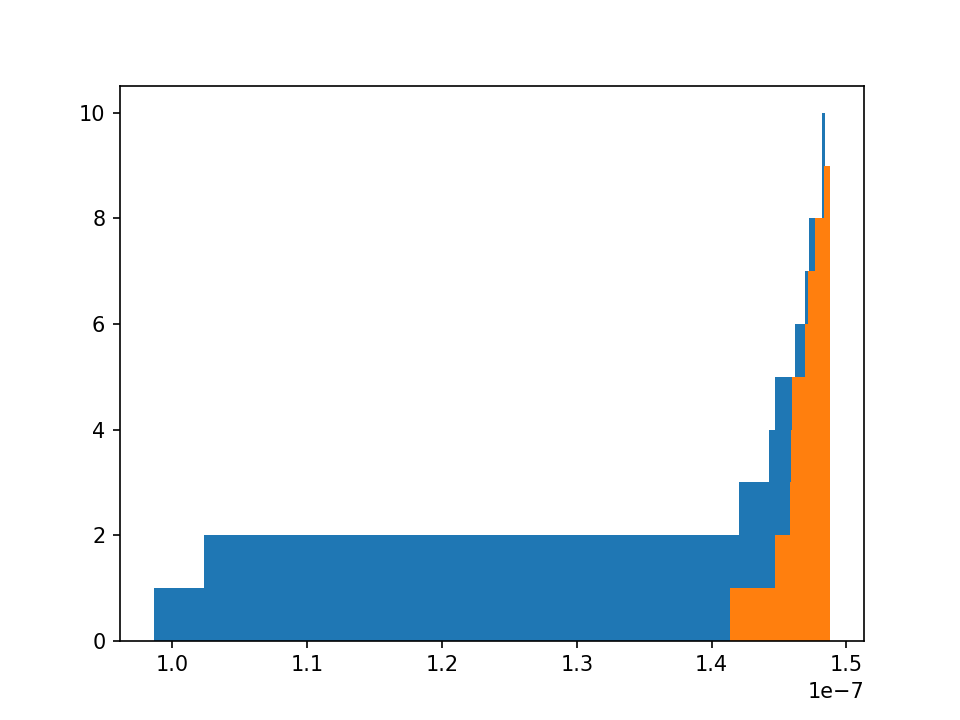

In [97]:
fig, ax = plt.subplots()
for idx in [1298, 1301]:
    plot_hist_by_id(idx, ax = ax)

In [105]:
# Use this code for T-dependent tasks
# Using PID 30,5,1 & htr range 10mA for T8 upto 550mK
# The LS370 htr driver was coded in meas_util.py instead of qcode  
 
setT8_lst = [ .100, .150, .200, .300] 

tolerT8 = 0.02
chkrepeat = 20
chkperiod_sec = 2

Tnow_alllst = []
timer_lst = []

htr.HTRset('10mA')

for setT8 in setT8_lst:
#     htr.setpoint(setT8)
    htr.Tset(setT8)
    print('ramping T8 to {}K...'.format(si_format(setT8)))
    if setT8 < 60e-3:
        time.sleep(300)
    else:
        time.sleep(30)
    Tnow_lst = []

    t0 = time.time()
    count_T = 0
    while count_T < chkrepeat:
        T_now = T8.get()
        if (1-tolerT8)*setT8 <= T_now <= (1+tolerT8)*setT8 :
            count_T +=1
            Tnow_lst.append(T_now)
            time.sleep(chkperiod_sec)
        elif count_T >= 1 :
            count_T -=1
    t1 = time.time()
    
    timer_lst.append(t1-t0)
    Tnow_alllst.append(Tnow_lst)

    # insert here the repeatative work to be done at each T
    for cos in [1, 0.7, 0.3]:
        B = cos_to_B(cos)
        Bfield.set(B)
        Isws =  meas_hist(1000)
        save_hist(Isws, '6220 cos = {:1.2f}'.format(cos))
    

# htr.setpoint(0.030)
htr.Tset(0.030)

ramping T8 to 100.0 mK...



Starting experimental run with id: 1303
Run # 1303, 6220 cos = 1.00 @T =100.7mK saved



Starting experimental run with id: 1304
Run # 1304, 6220 cos = 0.70 @T =100.0mK saved



Starting experimental run with id: 1305
Run # 1305, 6220 cos = 0.30 @T =100.2mK saved
ramping T8 to 150.0 mK...



Starting experimental run with id: 1306
Run # 1306, 6220 cos = 1.00 @T =149.1mK saved



Starting experimental run with id: 1307
Run # 1307, 6220 cos = 0.70 @T =149.1mK saved



Starting experimental run with id: 1308
Run # 1308, 6220 cos = 0.30 @T =148.2mK saved
ramping T8 to 200.0 mK...



Starting experimental run with id: 1309
Run # 1309, 6220 cos = 1.00 @T =200.7mK saved



Starting experimental run with id: 1310
Run # 1310, 6220 cos = 0.70 @T =202.4mK saved



Starting experimental run with id: 1311
Run # 1311, 6220 cos = 0.30 @T =198.1mK saved
ramping T8 to 300.0 mK...



Starting experimental run with id: 1312
Run # 1312, 6220 cos = 1.00 @T =301.6mK saved



Starting experimental run with id: 1313
Run # 1313, 6220 cos = 0.70 @T =299.5mK saved



Starting experimental run with id: 1314
Run # 1314, 6220 cos = 0.30 @T =300.8mK saved


'setpoint changed to 30.0 mK'

In [39]:
Vmeter.init('fast 6')
IVC_udu (amp=300e-9, stp=4e-9, Gain=100, R_bias=11.2e6, Attn=1, tfsstb = 0.1)

Starting experimental run with id: 1231



1231

In [119]:
def meas_hist(N):

    Isws = []



    i = 0
    istep = .2e-9
    i0 = 20e-9

    Isrc.I.set(i0)
    time.sleep(1)
    Isrc.I.set(-i0)
    time.sleep(1)
    V_off = meas_Voffset(0)

    for n in tqdm_notebook(range(N)):

        V = V_off

        while (V - V_off) < 50e-6:
            

            i += istep
            Isrc.I.set(i)
            V = Vmeter.V.get()



        Isws.append(i)

        Isrc.I.set(-i0)
        time.sleep(1)
        i = np.mean(Isws)*.7
        Isrc.I.set(i)
        time.sleep(0.1)

    return Isws
    

        

In [118]:
.2e-9/7e-3

2.8571428571428572e-08

In [117]:
meas_hist(10)

0.013000726699829102
0.00700068473815918
0.007000446319580078
0.00700068473815918
0.013000726699829102
0.0060002803802490234
0.007000446319580078
0.006000041961669922
0.007000446319580078
0.0070002079010009766
0.006000041961669922
0.013000726699829102
0.007000446319580078
0.0070002079010009766
0.013000726699829102
0.00700068473815918
0.0070002079010009766
0.0060002803802490234
0.0070002079010009766
0.0070002079010009766
0.007000446319580078
0.014000654220581055
0.0060002803802490234
0.00700068473815918
0.014000892639160156
0.006000041961669922
0.0070002079010009766
0.007000446319580078
0.006000041961669922
0.007000446319580078
0.007000446319580078
0.013000726699829102
0.007000446319580078
0.006000518798828125
0.014000892639160156
0.0060002803802490234
0.0060002803802490234
0.0070002079010009766
0.00700068473815918
0.0060002803802490234
0.007000446319580078
0.013000965118408203
0.0070002079010009766
0.006000041961669922
0.007000446319580078
0.0060002803802490234
0.00700068473815918
0.00

0.007000446319580078
0.0060002803802490234
0.014000892639160156
0.006000518798828125
0.0060002803802490234
0.007000446319580078
0.00700068473815918
0.007000446319580078
0.014000654220581055
0.006000518798828125
0.0070002079010009766
0.007000446319580078
0.013000965118408203
0.007000446319580078
0.007000446319580078
0.007000446319580078
0.0060002803802490234
0.006000518798828125
0.014000654220581055
0.006000041961669922
0.006000518798828125
0.0070002079010009766
0.0060002803802490234
0.007000446319580078
0.0070002079010009766
0.014000654220581055
0.006000518798828125
0.007000446319580078
0.013000965118408203
0.007000446319580078
0.0070002079010009766
0.0060002803802490234
0.007000446319580078
0.0070002079010009766
0.0060002803802490234
0.013000965118408203
0.0070002079010009766
0.006000518798828125
0.0070002079010009766
0.014000654220581055
0.0060002803802490234
0.007000446319580078
0.006000041961669922
0.00700068473815918
0.0070002079010009766
0.013000965118408203
0.0070002079010009766

0.0060002803802490234
0.013000726699829102
0.007000446319580078
0.0060002803802490234
0.013000726699829102
0.007000446319580078
0.006000518798828125
0.0070002079010009766
0.007000446319580078
0.0070002079010009766
0.007000446319580078
0.013000726699829102
0.0060002803802490234
0.006000518798828125
0.013000726699829102
0.007000446319580078
0.0060002803802490234
0.0060002803802490234
0.0070002079010009766
0.007000446319580078
0.0060002803802490234
0.013000726699829102
0.0070002079010009766
0.007000446319580078
0.013000726699829102
0.0070002079010009766
0.007000446319580078
0.0060002803802490234
0.00700068473815918
0.0070002079010009766
0.00700068473815918
0.014000654220581055
0.007000446319580078
0.006000041961669922
0.006000518798828125
0.007000446319580078
0.007000446319580078
0.007000446319580078
0.014000654220581055
0.007000446319580078
0.00700068473815918
0.014000892639160156
0.007000446319580078
0.006000518798828125
0.0070002079010009766
0.007000446319580078
0.00700068473815918
0.0

0.007000446319580078
0.013000726699829102
0.0070002079010009766
0.0060002803802490234
0.013000965118408203
0.0060002803802490234
0.013000726699829102
0.013000726699829102
0.014000892639160156
0.0070002079010009766
0.007000446319580078
0.013000726699829102
0.007000446319580078
0.007000446319580078
0.0070002079010009766
0.013000726699829102
0.0070002079010009766
0.006000041961669922
0.0070002079010009766
0.007000446319580078
0.0070002079010009766
0.013000965118408203
0.007000446319580078
0.0070002079010009766
0.007000446319580078
0.014000654220581055
0.0060002803802490234
0.0070002079010009766
0.007000446319580078
0.0070002079010009766
0.007000446319580078
0.013000726699829102
0.0070002079010009766
0.0070002079010009766
0.006000041961669922
0.013000726699829102
0.0060002803802490234
0.007000446319580078
0.0070002079010009766
0.006000518798828125
0.0070002079010009766
0.007000446319580078
0.014000654220581055
0.006000518798828125
0.007000446319580078
0.013000726699829102
0.007000684738159

0.0060002803802490234
0.00700068473815918
0.0070002079010009766
0.007000446319580078
0.007000446319580078
0.013000726699829102
0.0060002803802490234
0.0070002079010009766
0.0070002079010009766
0.0060002803802490234
0.0070002079010009766
0.006000518798828125
0.013000726699829102
0.0070002079010009766
0.007000446319580078
0.0070002079010009766
0.013000726699829102
0.0060002803802490234
0.00700068473815918
0.0070002079010009766
0.007000446319580078
0.0070002079010009766
0.013000726699829102
0.007000446319580078
0.0070002079010009766
0.006000518798828125
0.013000726699829102
0.006000518798828125
0.006000041961669922
0.007000446319580078
0.0070002079010009766
0.006000518798828125
0.013000726699829102
0.007000446319580078
0.0070002079010009766
0.007000446319580078
0.014000892639160156
0.0060002803802490234
0.006000518798828125
0.0060002803802490234
0.0070002079010009766
0.00700068473815918
0.0060002803802490234
0.014000654220581055
0.007000446319580078
0.007000446319580078
0.0140008926391601

0.008000612258911133
0.013000726699829102
0.0070002079010009766
0.00700068473815918
0.007000446319580078
0.007000446319580078
0.0070002079010009766
0.00700068473815918
0.013000726699829102
0.007000446319580078
0.0070002079010009766
0.013000965118408203
0.006000518798828125
0.0060002803802490234
0.00700068473815918
0.007000446319580078
0.007000446319580078
0.007000446319580078
0.013000965118408203
0.0070002079010009766
0.007000446319580078
0.007000446319580078
0.00700068473815918
0.0060002803802490234
0.006000518798828125
0.014000892639160156
0.007000446319580078
0.006000041961669922
0.014000892639160156
0.006000518798828125
0.0070002079010009766
0.007000446319580078
0.0070002079010009766
0.007000446319580078
0.00700068473815918
0.014000892639160156
0.007000446319580078
0.00700068473815918
0.013000726699829102
0.007000446319580078
0.00700068473815918
0.0060002803802490234
0.00700068473815918
0.007000446319580078
0.0070002079010009766
0.014000654220581055
0.007000446319580078
0.007000207

KeyboardInterrupt: 

check delay between source and DUT input

check how hisogram depends on
  -  scanning speed (est ramping rate)
  -  current direction
  -  filtering
  -  leads floating
  
for the best setup:
    - B scan (base T, for cos = 1, 0.6, 0.3)
    - T scan (T = 100, 150, 200, 300, 400, 500)

<IPython.core.display.Javascript object>


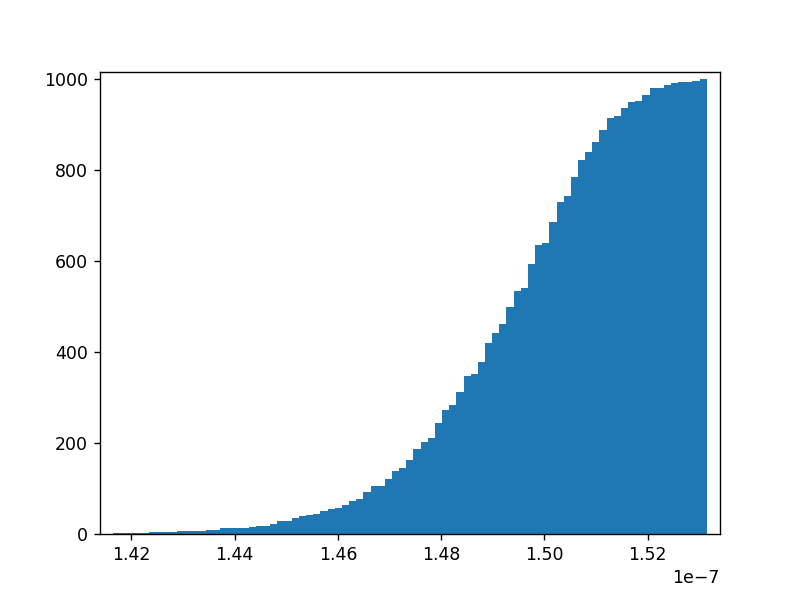

Starting experimental run with id: 1226


In [273]:
fig, ax = plt.subplots()
ax.hist(Isws, bins = 201, cumulative = True )
save_hist(Isws)

In [274]:
np.std(Isws)

1.9762474430539192e-09

<IPython.core.display.Javascript object>


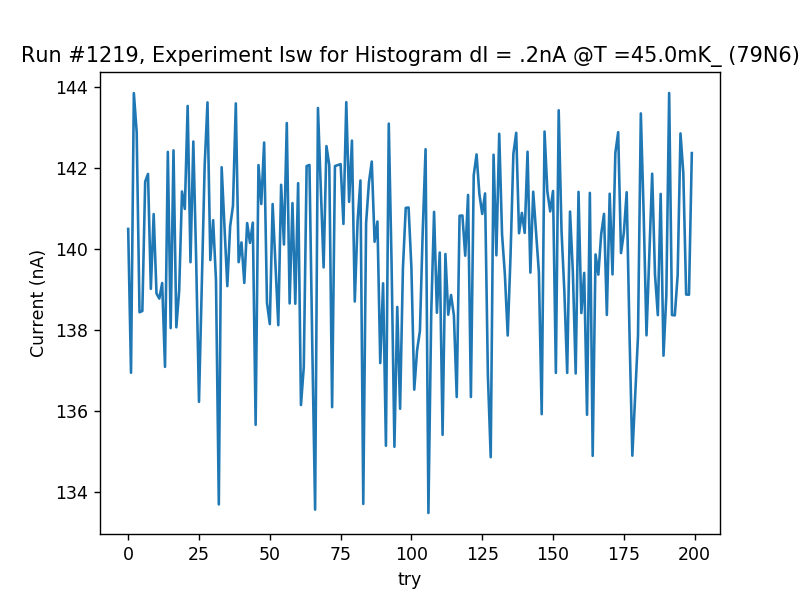

([<matplotlib.axes._subplots.AxesSubplot at 0x1ccbfa90>], [None])

In [216]:
plot_by_id(1219)

In [181]:
for i in tqdm_notebook(range(100)):
    Vmeter.V.get()

### Results

#### $2.2 \times 1.7 \mu m$   chain (N0) / Single SQUID (N6) / chain (N5) with $E_J = 2K$

<IPython.core.display.Javascript object>


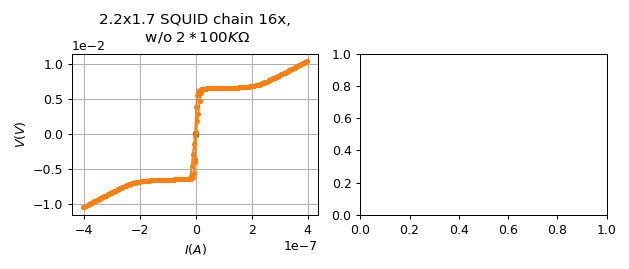

In [99]:
SAMPLE = '79N0' #1ab,2ab
qc.config["core"]["db_location"] = r'\\JOSH-PC\OurData_OneDrive\Experiments_{}.db'.format(SAMPLE)

plt.close('all')
f,ax=plt.subplots(1,2, figsize=(7,3))

labelL = ['$16K$',
          '$43mK$']
for i,v in enumerate([9,10]):
    data = get_data_by_id(v)
    Is = data[0][0]['data']
    Vs = data[0][1]['data']
    slope, intercept, r_value, p_value, std_err = stats.linregress(Is, Vs)
    ax[0].plot(Is, Vs, '.', ls='-',label = labelL[i]+', {}$\Omega$'.format(si_format(slope)))

ax[0].set_xlabel('$I (A)$')
ax[0].set_ylabel('$V (V)$')
ax[0].set_title('2.2x1.7 SQUID chain 16x,\n w/o $2* 100K\Omega$', pad=10)
# ax[0].legend()
ax[0].grid()
ax[0].ticklabel_format(axis='both', style='sci', scilimits=(0, 2))

plt.tight_layout()

<IPython.core.display.Javascript object>


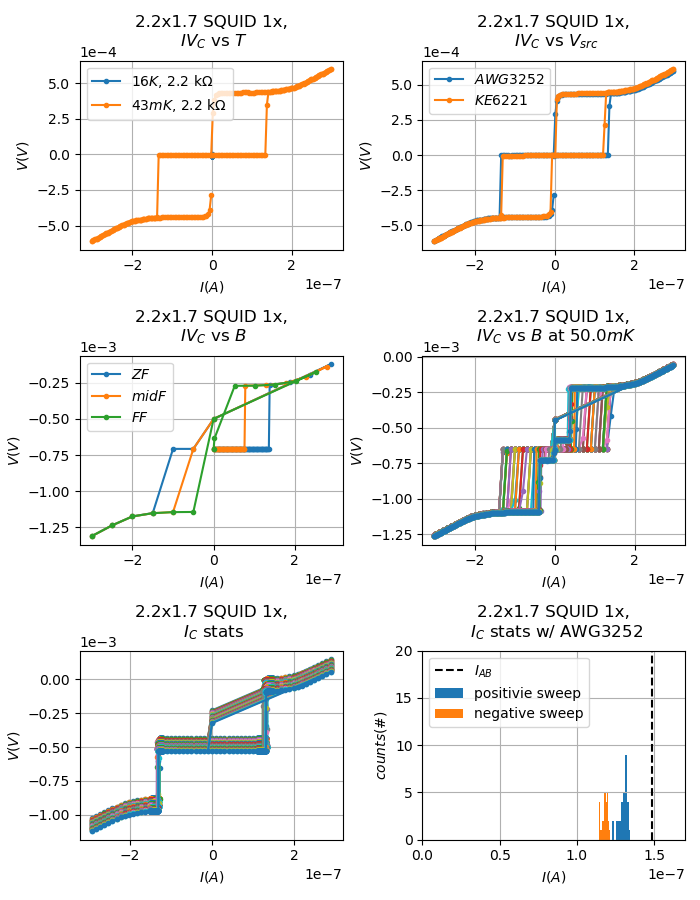

In [213]:
SAMPLE = '79N6' #3ab,4ab
qc.config["core"]["db_location"] = r'\\JOSH-PC\OurData_OneDrive\Experiments_{}.db'.format(SAMPLE)

plt.close('all')
f,ax=plt.subplots(3,2, figsize=(7,9))
# ax.flatten()

labelL = ['$16K$' ,
          '$43mK$']
for i,v in enumerate([1,4]):
    data = get_data_by_id(v)
    Is = data[0][0]['data']
    Vs = data[0][1]['data']#-data[0][1]['data'][0]
    slope, intercept, r_value, p_value, std_err = stats.linregress(Is, Vs)
    ax[0,0].plot(Is, Vs, '.', ls='-',label = labelL[i]+', {}$\Omega$'.format(si_format(slope)))
ax[0,0].set_xlabel('$I (A)$')
ax[0,0].set_ylabel('$V (V)$')
ax[0,0].set_title('2.2x1.7 SQUID 1x,\n $IV_{C}$ vs $T$', pad=10)
ax[0,0].legend()
ax[0,0].grid()
ax[0,0].ticklabel_format(axis='both', style='sci', scilimits=(0, 2))

labelL1 = ['$AWG3252$',
          '$KE6221$']
for i,v in enumerate([4,9]):
    data = get_data_by_id(v)
    Is = data[0][0]['data']
    Vs = data[0][1]['data']#-data[0][1]['data'][0]
    ax[0,1].plot(Is, Vs, '.', ls='-',label = labelL1[i])
ax[0,1].set_xlabel('$I (A)$')
ax[0,1].set_ylabel('$V (V)$')
ax[0,1].set_title('2.2x1.7 SQUID 1x,\n $IV_{C}$ vs $V_{src}$', pad=10)
ax[0,1].legend()
ax[0,1].grid()
ax[0,1].ticklabel_format(axis='both', style='sci', scilimits=(0, 2))

labelR = ['$ZF$'  ,
          '$midF$',
          '$FF$'   ]
for i,v in enumerate([105,106,107]):#
    data = get_data_by_id(v)
    Is = data[0][0]['data']
    Vs = data[0][1]['data']#-data[0][1]['data'][0]
    ax[1,0].plot(Is, Vs, '.', ls='-',label = labelR[i])
ax[1,0].set_xlabel('$I (A)$')
ax[1,0].set_ylabel('$V (V)$')
ax[1,0].set_title('2.2x1.7 SQUID 1x,\n $IV_{C}$ vs $B$', pad=10)
ax[1,0].legend()
ax[1,0].grid()
ax[1,0].ticklabel_format(axis='both', style='sci', scilimits=(0, 2))

T = 50e-3
for i,v in enumerate(ex79N6['ids'][ex79N6['T']==T].tolist()[0]):
    data = get_data_by_id(v)
    Is = data[0][0]['data']
    Vs = data[0][1]['data']#-data[0][1]['data'][0]
    ax[1,1].plot(Is, Vs, '.', ls='-')
ax[1,1].set_xlabel('$I (A)$')
ax[1,1].set_ylabel('$V (V)$')
ax[1,1].set_title('2.2x1.7 SQUID 1x,\n $IV_C$ vs $B$ at ${}K$'.format(si_format(T)), pad=10)
ax[1,1].grid()
ax[1,1].ticklabel_format(axis='both', style='sci', scilimits=(0, 2))

for i,v in enumerate(range(74,104+1)):#56,
    data = get_data_by_id(v)
    Is = data[0][0]['data']
    Vs = data[0][1]['data']#-data[0][1]['data'][0]
    ax[2,0].plot(Is, Vs, '.', ls='-')
ax[2,0].set_xlabel('$I (A)$')
ax[2,0].set_ylabel('$V (V)$')
ax[2,0].set_title('2.2x1.7 SQUID 1x,\n $I_C$ stats', pad=10)
ax[2,0].grid()
ax[2,0].ticklabel_format(axis='both', style='sci', scilimits=(0, 2))

Iclstp = np.asarray([])
for i,v in enumerate(range(74,104+1)):
    data = get_data_by_id(v)
    Is = data[0][0]['data']
    Vs = data[0][1]['data']-data[0][1]['data'][0]
    for j,w in enumerate(np.diff(Vs)[:int(len(np.diff(Vs))/2)-30]):
        if abs(w) > 1e-4:
            Iclstp = np.append(Iclstp,np.abs(Is[j]))
            break
Iclstn = np.asarray([])
for i,v in enumerate(range(74,104+1)):
    data = get_data_by_id(v)
    Is = data[0][0]['data']
    Vs = data[0][1]['data']-data[0][1]['data'][0]
    for j,w in enumerate(np.diff(Vs)[int(len(np.diff(Vs))/2)+30:]):
        if abs(w) > 1e-4:
            Iclstn = np.append(Iclstn,np.abs(Is[j]))
            break
ax[2,1].plot(np.full(len(range(0,100)),148.8e-9),range(0,100),'--', label = '$I_{AB}$', color = 'black')
ax[2,1].hist(Iclstp, label = 'positivie sweep')
ax[2,1].hist(Iclstn, label = 'negative sweep')

ax[2,1].set_xlim(0,170e-9)
ax[2,1].set_ylim(0,20)
ax[2,1].set_xlabel('$I (A)$')
ax[2,1].set_ylabel('$counts (\#)$')
ax[2,1].set_title('2.2x1.7 SQUID 1x,\n $I_C$ stats w/ AWG3252', pad=10)
ax[2,1].legend()
ax[2,1].grid()

plt.tight_layout()

In [ ]:
SAMPLE = '79N6' #3ab,4ab
qc.config["core"]["db_location"] = r'\\JOSH-PC\OurData_OneDrive\Experiments_{}.db'.format(SAMPLE)

plt.close('all')
f,ax=plt.subplots(2,1, figsize=(4,6))
ax = ax.flatten()

Iclstp = np.asarray([])
for i,v in enumerate(range(74,104+1)):
    data = get_data_by_id(v)
    Is = data[0][0]['data']
    Vs = data[0][1]['data']-data[0][1]['data'][0]
    for j,w in enumerate(np.diff(Vs)[:int(len(np.diff(Vs))/2)-30]):
        if abs(w) > 1e-4:
            Iclstp = np.append(Iclstp,np.abs(Is[j]))
            break
Iclstn = np.asarray([])
for i,v in enumerate(range(74,104+1)):
    data = get_data_by_id(v)
    Is = data[0][0]['data']
    Vs = data[0][1]['data']-data[0][1]['data'][0]
    for j,w in enumerate(np.diff(Vs)[int(len(np.diff(Vs))/2)+30:]):
        if abs(w) > 1e-4:
            Iclstn = np.append(Iclstn,np.abs(Is[j]))
            break
ax[0].plot(np.full(len(range(0,1000)),148.8e-9),range(0,1000),'--', label = '$I_{AB}; 35mK$', color = 'black')
ax[0].hist(Iclstp, label = 'pos. swp')
ax[0].hist(Iclstn, label = 'neg. swp')
ax[0].set_xlim(0,170e-9)
ax[0].set_ylim(0,20)
ax[0].set_xlabel('$I (A)$')
ax[0].set_ylabel('$counts (\#)$')
ax[0].set_title('2.2x1.7 SQUID 1x,\n $I_C$ stats w/ AWG3252, 12/11', pad=10)
ax[0].legend()
ax[0].grid()

label = ['150mK', '200mK', '250mK', '300mK']
for i,v in enumerate([1204,1206,1208,1210]):#56,
    data = get_data_by_id(v)
    Ic = data[0][1]['data']#-data[0][1]['data'][0]
    ax[1].hist(Ic, label = label[i])
ax[1].set_xlabel('$I (A)$')
ax[1].set_ylabel('$try (\#)$')
ax[1].set_xlim(0,170e-9)
ax[1].set_ylim(0,200)
ax[1].set_title('2.2x1.7 SQUID 1x,\n $I_C$ stats w/ AWG3252, 12/12', pad=10)
ax[1].grid()
ax[1].legend()
ax[1].ticklabel_format(axis='both', style='sci', scilimits=(0, 2))

plt.tight_layout()

In [ ]:
SAMPLE = '79N6' #3ab,4ab
qc.config["core"]["db_location"] = r'\\JOSH-PC\OurData_OneDrive\Experiments_{}.db'.format(SAMPLE)

plt.close('all')
f,ax=plt.subplots(1,2, figsize=(7,3))
ax = ax.flatten()

label = ['HP fast 4', 'HP fast 6']
for i,v in enumerate([1229,1231]):#fast 4, fast 6
    data = get_data_by_id(v)
    Is = data[0][0]['data']
    Vs = data[0][1]['data']-data[0][1]['data'][0]
    ax[0].plot(Is,Vs,'.',ls='-', label = label[i])
ax[0].set_xlabel('$I (A)$')
ax[0].set_ylabel('$try (\#)$')
ax[0].set_title('2.2x1.7 SQUID 1x,\n Vsrc speed', pad=10)
ax[0].grid()
ax[0].legend()
ax[0].ticklabel_format(axis='both', style='sci', scilimits=(0, 2))

plt.tight_layout()

<IPython.core.display.Javascript object>


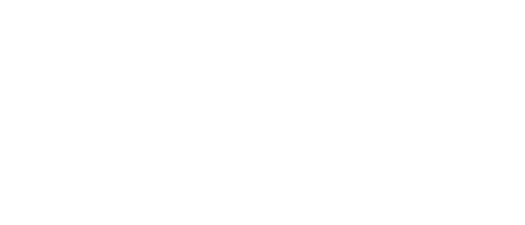

In [114]:
SAMPLE = '79N6'
qc.config["core"]["db_location"] = r'\\JOSH-PC\OurData_OneDrive\Experiments_{}.db'.format(SAMPLE)

plt.close('all')
f,ax=plt.subplots(1,2, figsize=(7,3))

labelL = ['$16K$',
          '$43mK$']
for i,v in enumerate(range(763,813+1)):#763,813+1
    data = get_data_by_id(v)
    Is = data[0][0]['data']
    Vs = data[0][1]['data']
    slope, intercept, r_value, p_value, std_err = stats.linregress(Is, Vs)
    ax[0].plot(Is, Vs, '.', ls='-')
ax[0].set_xlabel('$I (A)$')
ax[0].set_ylabel('$V (V)$')
ax[0].set_title('2.2x1.7 SQUID 1x,T = 50mK$', pad=10)
# ax[0].legend()
ax[0].grid()
ax[0].ticklabel_format(axis='both', style='sci', scilimits=(0, 2))

Iclstp = np.asarray([])
Blst = np.linspace(ZF, ZF + 1.0*dF, 51)
for i,v in enumerate(range(763,813+1)):
    data = get_data_by_id(v)
    Is = data[0][0]['data']
    Vs = data[0][1]['data']-data[0][1]['data'][0]
    for j,w in enumerate(np.diff(Vs)):
        if abs(w) > 1e-4:
            Iclstp = np.append(Iclstp,np.abs(Is[j]))
            break
ax[1].plot(np.cos(Blst/FF*np.pi/2), Iclstp, '.', ls='-')
Iclstp = np.asarray([])
Blst = np.linspace(ZF, ZF + 2.0*dF, 51)
for i,v in enumerate(range(1234,1284+1)):
    data = get_data_by_id(v)
    Is = data[0][0]['data']
    Vs = data[0][1]['data']-data[0][1]['data'][0]
    for j,w in enumerate(np.diff(Vs)):
        if abs(w) > 1e-4:
            Iclstp = np.append(Iclstp,np.abs(Is[j]))
            break
ax[1].plot(np.cos(Blst/FF*np.pi/2), Iclstp, '.', ls='-')
Iclstp = np.asarray([])
Blst = np.linspace(ZF - 2.0*dF, ZF + 2.0*dF, 51)
for i,v in enumerate(range(1315,1365+1)):
    data = get_data_by_id(v)
    Is = data[0][0]['data']
    Vs = data[0][1]['data']-data[0][1]['data'][0]
    for j,w in enumerate(np.diff(Vs)):
        if abs(w) > 1e-4:
            Iclstp = np.append(Iclstp,np.abs(Is[j]))
            break
ax[1].plot(np.cos(Blst/FF*np.pi/2), Iclstp, '.', ls='-')
ax[1].plot(np.cos(Blst/FF*np.pi/2),148.8e-9*np.abs(np.cos(Blst/FF*np.pi/2)),'--', label = '$I_{AB}*cos(B)$')
ax[1].set_xlabel('$cos(B)$')
ax[1].set_ylabel('$I_{SW} (A)$')
ax[1].set_title('2.2x1.7 SQUID 1x,\n $I_C$ vs $B$', pad=10)
# ax[1].legend()
ax[1].grid()
ax[1].ticklabel_format(axis='both', style='sci', scilimits=(0, 2))

plt.tight_layout()

<IPython.core.display.Javascript object>


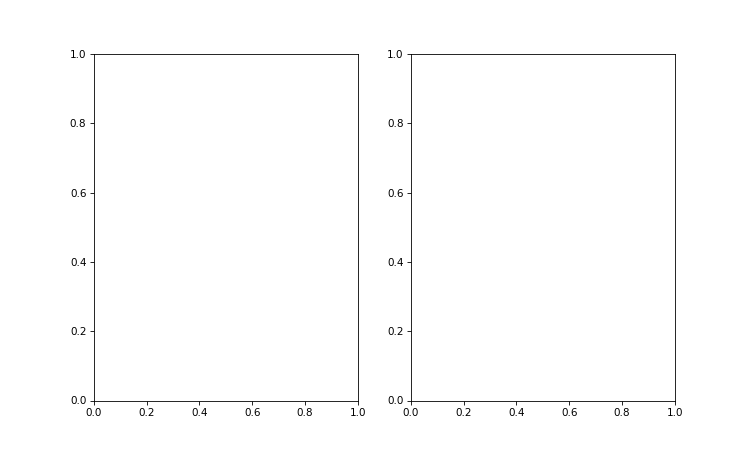

NameError: name 'ex79N6' is not defined

In [115]:
SAMPLE = '79N6' #3ab,4ab
qc.config["core"]["db_location"] = r'\\JOSH-PC\OurData_OneDrive\Experiments_{}.db'.format(SAMPLE)

plt.close('all')
f,ax=plt.subplots(1,2, figsize=(10,6))

T = 50e-3
num = -17
for i,v in enumerate(ex79N6['ids'][ex79N6['T']==T].tolist()[0][num:]):
    data = get_data_by_id(v)
    Is = data[0][0]['data']
    Vs = data[0][1]['data']-data[0][1]['data'][0]
    ax[0].plot(Is, Vs, '.', ls='-',label = '{}A'.format(si_format(ex79N6['B'][ex79N6['T']==T].tolist()[0][num:][i])))

ax[0].set_xlim(2e-8,4.5e-8)        
ax[0].set_ylim(0e-4,4.5e-4)        
ax[0].set_xlabel('$I (A)$')
ax[0].set_ylabel('$V (V)$')
ax[0].set_title('2.2x1.7 SQUID 1x,\n $IV_C$ vs $B$ at ${}K$'.format(si_format(T)), pad=10)

handles, labels = ax[0].get_legend_handles_labels()
ax[0].legend(handles[::-1], labels[::-1], loc='best', bbox_to_anchor=(0.5, 0., 0.9, 1.2))
ax[0].grid()
ax[0].ticklabel_format(axis='both', style='sci', scilimits=(0, 2))

Bshow = 169e-6
for i,v in enumerate(ex79N6['ids'][ex79N6['T']==T].tolist()[0]):
    if (np.abs(ex79N6['B'][ex79N6['T']==T].tolist()[0][i] - Bshow)/Bshow) < 1e-3 :
        data = get_data_by_id(v)
        Is = data[0][0]['data']
        Vs = data[0][1]['data']-data[0][1]['data'][0]
        ax[1].plot(Is, Vs, '.', ls='-')
        
ax[1].set_xlim(2e-8,4.5e-8)        
ax[1].set_ylim(0e-4,4.5e-4)        
ax[1].set_xlabel('$I (A)$')
ax[1].set_ylabel('$V (V)$')
ax[1].set_title('2.2x1.7 SQUID 1x,\n $IV_C$ vs $B$ at ${}K$'.format(si_format(T)), pad=10)
ax[1].grid()
ax[1].ticklabel_format(axis='both', style='sci', scilimits=(0, 2))

plt.tight_layout()

<IPython.core.display.Javascript object>


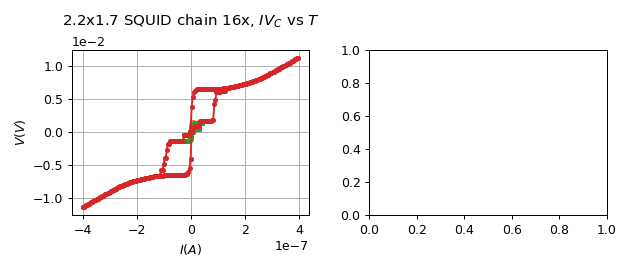

In [118]:
SAMPLE = '79N5' #6ab,7ba
qc.config["core"]["db_location"] = r'\\JOSH-PC\OurData_OneDrive\Experiments_{}.db'.format(SAMPLE)
initialise_database()

plt.close('all')
f,ax=plt.subplots(1,2, figsize=(7,3))

labelL = ['$16K$' ,
          '$43mK$',
          '$43mK$',
          '$43mK$']
for i,v in enumerate([1,2,3,4]):
    data = get_data_by_id(v)
    Is = data[0][0]['data']
    Vs = data[0][1]['data']
    slope, intercept, r_value, p_value, std_err = stats.linregress(Is, Vs)
    ax[0].plot(Is, Vs, '.', ls='-',label = labelL[i]+', {}$\Omega$'.format(si_format(slope)))

ax[0].set_xlabel('$I (A)$')
ax[0].set_ylabel('$V (V)$')
ax[0].set_title('2.2x1.7 SQUID chain 16x, $IV_{C}$ vs $T$', pad=20)
# ax[0].legend()
ax[0].grid()
ax[0].ticklabel_format(axis='both', style='sci', scilimits=(0, 2))

plt.tight_layout()

#### $0.7 \times 0.2 \mu m$ junction with $E_J = 117mK, E_C = 90mK$

<IPython.core.display.Javascript object>


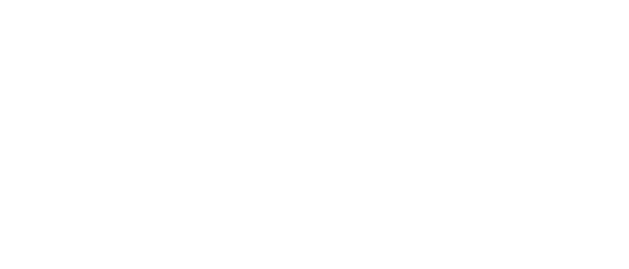

ValueError: Run with run_id 9 does not exist in the database

In [91]:
SAMPLE = '79N3' #8ab,9ab (9a is broken)
qc.config["core"]["db_location"] = r'\\JOSH-PC\OurData_OneDrive\Experiments_{}.db'.format(SAMPLE)
initialise_database()

plt.close('all')
f,ax=plt.subplots(1,2, figsize=(7,3))

labelL = ['$16K$',
          '$43mK$']
for i,v in enumerate([9,10]):
    data = get_data_by_id(v)
    Is = data[0][0]['data']
    Vs = data[0][1]['data']
    slope, intercept, r_value, p_value, std_err = stats.linregress(Is, Vs)
    ax[0].plot(Is, Vs, '.', ls='-',label = labelL[i]+', {}$\Omega$'.format(si_format(slope)))

ax[0].set_xlabel('$I (A)$')
ax[0].set_ylabel('$V (V)$')
ax[0].set_title('0.7x0.2 SQUID chain 16x, $IV_{C}$ vs $T$', pad=20)
# ax[0].legend()
ax[0].grid()
ax[0].ticklabel_format(axis='both', style='sci', scilimits=(0, 2))

plt.tight_layout()

#### $0.2 \times 0.2 \mu m$ junction with $E_J = 13mK, E_C = 593mK$

<IPython.core.display.Javascript object>


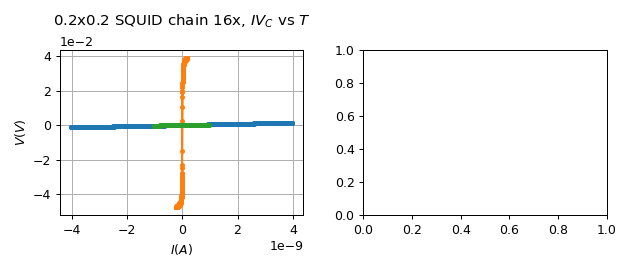

In [92]:
SAMPLE = '79N1' #11ab,12ab
qc.config["core"]["db_location"] = r'\\JOSH-PC\OurData_OneDrive\Experiments_{}.db'.format(SAMPLE)
initialise_database()

plt.close('all')
f,ax=plt.subplots(1,2, figsize=(7,3))

labelL = ['$65mK$',
          '$43mK$',
          '$16K$']
for i,v in enumerate([3,6,2]):
    data = get_data_by_id(v)
    Is = data[0][0]['data']
    Vs = data[0][1]['data']
    slope, intercept, r_value, p_value, std_err = stats.linregress(Is, Vs)
    ax[0].plot(Is, Vs, '.', ls='-',label = labelL[i]+', {}$\Omega$'.format(si_format(slope)))

ax[0].set_xlabel('$I (A)$')
ax[0].set_ylabel('$V (V)$')
ax[0].set_title('0.2x0.2 SQUID chain 16x, $IV_{C}$ vs $T$', pad=20)
# ax[0].legend()
ax[0].grid()
ax[0].ticklabel_format(axis='both', style='sci', scilimits=(0, 2))

plt.tight_layout()

#### $1.5 \times 1.0 \mu m$ junction with $E_J = 2.8K$

## Summary